In [1]:
import pandas as pd
import numpy as np
import math
import sys
import random
from pivottablejs import pivot_ui
import sklearn
from random import sample
from sklearn.neighbors import NearestNeighbors
import json
from scipy import stats

In [2]:
# Pearson Score
# ------------------------------------------------------------------------------------------------------------------
def pearson_calc(numbers_x, numbers_y):
    mean_x = 0.000
    mean_y = 0.000
    if(len(numbers_y)==0 and len(numbers_x)==0):
        mean_x = sum(numbers_x)/0.001
        mean_y = sum(numbers_y)/0.001
    elif(len(numbers_x)==0):
        mean_x = sum(numbers_x)/0.001
        mean_y = sum(numbers_y)/len(numbers_y)
    elif(len(numbers_y)==0):
        mean_x = sum(numbers_x)/len(numbers_x)
        mean_y = sum(numbers_y)/0.001
    else:
        mean_x = sum(numbers_x)/len(numbers_x)
        mean_y = sum(numbers_y)/len(numbers_y)
    
    subtracted_mean_x = [i - mean_x for i in numbers_x]
    subtracted_mean_y = [i - mean_y for i in numbers_y]

    x_times_y = [a * b for a, b in list(zip(subtracted_mean_x, subtracted_mean_y))]

    x_squared = [i * i for i in numbers_x]
    y_squared = [i * i for i in numbers_y]
    
    N = sum(x_times_y)
    D = math.sqrt(sum(x_squared) * sum(y_squared))
    if (D !=0):
        return N/D
    else:
        return N/0.001

In [3]:
def match_cal(user1,user2):
    match = 0
    df_u1 = user1.values.tolist()
    df_u2 = user2.values.tolist()
    df_u1 =  [y for x in df_u1 for y in x] 
    df_u2 =  [y for x in df_u2 for y in x] 
    for i in range(0,len(df_u2)):
        if(df_u2[i]==1 and df_u1[i]==1):
            match=match+1
        else:
            match=match+0.001
#     print('match',match)
    pearson_correlation_val = pearson_calc(df_u1,df_u2)
    return match,pearson_correlation_val

In [4]:
def pearson_score(user1,user2):
    '''
    user1 & user2 : user ids of two users between which similarity score is to be calculated.
    '''
    # A list of categories joined by both the users.
    both_match_count, score = match_cal(user1,user2)
    
#     print('both matches :',both_match_count)
    # Returning '0' if no common values.
    if both_match_count == 0 :
        return 0
    return score

In [5]:
def find_k_neighbours(df,k):
    order = np.argsort(df.values, axis=1)[:, :k]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False).iloc[:k].index, index=['top{}'.format(i) for i in range(1, k+1)]), axis=1)
    return df

In [6]:
def weighted_average_over_scores(score,weights):
    form_eq = []
    for i in range(0,len(score)):
        val = score[i]**weights[i]
        form_eq.append(val)
    product_val = np.prod(form_eq)
    
    sum_weights = 0
    for i in range(0,len(weights)):
        sum_weights = sum_weights + weights[i]
    
    sum_weights = 1 / (sum_weights)
    result_val = product_val**sum_weights
    result_val = stats.gmean(result_val)
    
    
    if(math.isnan(result_val)):
        print("Something is wrong!")
        return 0.001
    elif(int(result_val) ==0):
        print("Something is wrong! - 2")
        return 0.001
    else:
        print("OK!")
        return result_val

In [7]:
def geom_mean(scores,weights):    
    a = []
    for i in range(0,len(scores)):
        val = scores[i]*weights[i]
        a.append(val)
    a = np.array(a)
    pos = a[a > 0]
    pos_mean = stats.gmean(pos)
    pos_prop = pos.size / a.size
    
    neg = a[a < 0]
    neg = np.abs(neg)
    neg_mean = stats.gmean(neg) if neg.size > 0 else 0
    neg_prop = neg.size / a.size
    
    return (pos_mean * pos_prop) - (neg_mean * neg_prop)

In [8]:
def har_mean(scores,weights):
    a = []
    for i in range(0,len(scores)):
        val = scores[i]*weights[i]
        a.append(val)
    a = np.array(a)
    return (len(a) / sum(1 / n for n in a))

In [9]:
def gbellmf(x):
    return 1.00 / (1.00 + np.abs((x - 0.001) / 0.001) ** (2 * 0.001))

In [10]:
# ------------------------------------------------------------------------------------------------------------------

In [11]:
data_users = pd.read_csv('user_cat.csv',index_col=0)
data_users.head()

C:\Users\tusha\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,member_id,category_id,group_id,rating
0,3,2,490552,4.67
1,210,2,490552,4.67
2,357518,2,490552,4.67
3,511008,2,490552,4.67
4,915553,2,490552,4.67


In [12]:
data_users.size

12511788

In [13]:
data_users.shape

(3127947, 4)

In [14]:
tester = data_users.sample(n=1000).copy()
tester.head()

,member_id,category_id,group_id,rating
1373571,40306002,34,1642835,4.80
1434694,178513572,30,1684051,4.22
259043,40827052,16,3324842,4.75
1599173,77440242,2,1645494,4.63
516392,189020506,34,1561620,4.75


In [15]:
tester.shape

(1000, 4)

In [16]:
# Creating a pivot table based on above random subset of data

In [17]:
tester['values']=1

In [18]:
# Checking if the dataset for values
tester.head()

,member_id,category_id,group_id,rating,values
1373571,40306002,34,1642835,4.80,1
1434694,178513572,30,1684051,4.22,1
259043,40827052,16,3324842,4.75,1
1599173,77440242,2,1645494,4.63,1
516392,189020506,34,1561620,4.75,1


In [19]:
df_pivot = tester.pivot_table(index=['member_id'], columns=['category_id'],values='values').fillna(0)
df_pivot.head()

category_id,1,2,3,4,5,6,8,9,10,11,...,26,27,28,29,30,31,32,33,34,36
member_id,,,,,,,,,,,,,,,,,,,,,
207458,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
340894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
920153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1004248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# pivot_ui(df_pivot,rows=['member_id'], cols=['category_id'],outfile_path="./data_json/members_category_pivot.html")

In [21]:
# Shape of the pivot table
df_pivot.shape

(997, 32)

In [22]:
score_per_user_match = []
member_vals = []
index_list = []
for index,row in df_pivot.iterrows():
    index_list.append(index)

In [23]:
# Displaying all the members in the above pivot table
print(len(index_list))

997


In [24]:
scores = []
members1 = []
members2 = []
result = []
for i in range(0,len(index_list)):
#     print('user 1 --',user1)
    members1.append(index_list[i])
    user1 = df_pivot.iloc[i:i+1]
    for j in range(0,len(index_list)):
        user2 = df_pivot.iloc[j:j+1]
#         print('user 2 --',user2)
        score = pearson_score(user1,user2)
        scores.append(score)
        members2.append(index_list[j])
        list_add = []
        list_add.append(index_list[i])
        list_add.append(index_list[j])
        list_add.append(score)
        result.append(list_add)

In [25]:
checking = pd.DataFrame(result, columns = ['users_A', 'users_B','scores']) 
checking.head()

,users_A,users_B,scores
0,207458,207458,0.96875
1,207458,301575,-0.03125
2,207458,340894,-0.03125
3,207458,920153,-0.03125
4,207458,1004248,-0.03125


In [26]:
df_pivot_new=checking.pivot_table(index=['users_A'], columns=['users_B'], values = 'scores').fillna(0)
df_pivot_new.head()

users_B,207458,301575,340894,920153,1004248,1237529,1811156,1883022,2005305,2378358,...,239200740,239284494,239515342,239540866,239655255,239665444,239774336,240527919,240792702,240794539
users_A,,,,,,,,,,,,,,,,,,,,,
207458,0.96875,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,...,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125
301575,-0.03125,0.96875,0.96875,0.96875,-0.03125,0.96875,-0.03125,-0.03125,-0.03125,0.96875,...,0.96875,-0.03125,-0.03125,0.96875,0.96875,0.96875,0.96875,-0.03125,0.96875,0.96875
340894,-0.03125,0.96875,0.96875,0.96875,-0.03125,0.96875,-0.03125,-0.03125,-0.03125,0.96875,...,0.96875,-0.03125,-0.03125,0.96875,0.96875,0.96875,0.96875,-0.03125,0.96875,0.96875
920153,-0.03125,0.96875,0.96875,0.96875,-0.03125,0.96875,-0.03125,-0.03125,-0.03125,0.96875,...,0.96875,-0.03125,-0.03125,0.96875,0.96875,0.96875,0.96875,-0.03125,0.96875,0.96875
1004248,-0.03125,-0.03125,-0.03125,-0.03125,0.96875,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,...,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125,-0.03125


In [27]:
# Finding the 3 best suited neighboours for each member in the pivot table which is our user-user matrix

In [28]:
# df_pivot_new.to_json(r'./data_json/user_user_matrix_normal.json')

In [29]:
# pivot_ui(df_pivot_new,rows=['users_A'], cols=['users_B'],outfile_path="./data_json/user_user_pivot.html")

In [30]:
neigh_3 = find_k_neighbours(df_pivot_new,5)
neigh_3.head()

,top1,top2,top3,top4,top5
users_A,,,,,
207458,207458,204287520,222627007,90690752,226557421
301575,240794539,198610210,42738582,196062557,196434316
340894,240794539,198610210,42738582,196062557,196434316
920153,240794539,198610210,42738582,196062557,196434316
1004248,15964391,98672292,135639482,194124536,188448722


In [31]:
user_list = list(neigh_3.index)
user_list = sample(user_list, 5)
print(user_list)

[9280932, 159387072, 43256742, 211591350, 39868862]


<b> Converting the User-List to JSON

In [32]:
# with open('./data_json/user_list.json', 'w') as json_file:
#     json.dump(user_list, json_file)

<b> Converting neirest neigbour matrix to json

In [33]:
# neigh_3.to_json(r'./data_json/neigh_3.json')

In [34]:
# GEtting the user from the "USER_LIST"
selected_user = user_list[1]

In [35]:
# We could iterate over these users to generate all static data

In [36]:
user_val = df_pivot.loc[selected_user:selected_user]

In [37]:
user_val

category_id,1,2,3,4,5,6,8,9,10,11,...,26,27,28,29,30,31,32,33,34,36
member_id,,,,,,,,,,,,,,,,,,,,,
159387072,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [38]:
# Now we are finding the adjacent members whom the selected user shares the most compatibility with

In [39]:
selected_users_check = []
neigh_3 = neigh_3.loc[selected_user]
for i in neigh_3:
    if(i not in selected_users_check and (i is not None)):
        selected_users_check.append(i)
member_list=[]
for i in range(0,len(selected_users_check)):
    if(selected_user == selected_users_check[i]):
        pass
    else:
        member_list.append(selected_users_check[i])

In [40]:
# All the selected members from the above data - member_list
print(member_list)

[214842733, 210444159, 13357543, 208356602]


In [41]:
tester.head()

,member_id,category_id,group_id,rating,values
1373571,40306002,34,1642835,4.80,1
1434694,178513572,30,1684051,4.22,1
259043,40827052,16,3324842,4.75,1
1599173,77440242,2,1645494,4.63,1
516392,189020506,34,1561620,4.75,1


In [42]:
copy_data = data_users.copy()

In [43]:
copy_data.head()

,member_id,category_id,group_id,rating
0,3,2,490552,4.67
1,210,2,490552,4.67
2,357518,2,490552,4.67
3,511008,2,490552,4.67
4,915553,2,490552,4.67


In [44]:
copy_data.shape

(3127947, 4)

In [45]:
filter_groups_mem_info = copy_data['member_id'].isin(member_list)
copy_data.where(filter_groups_mem_info,inplace=True)
copy_data = copy_data.dropna()
copy_data.head()

,member_id,category_id,group_id,rating
15921,208356602.0,34.0,1515830.0,4.71
18563,13357543.0,34.0,1574965.0,4.57
76264,13357543.0,34.0,2829432.0,4.77
154856,13357543.0,34.0,263790.0,4.64
180766,13357543.0,34.0,1484316.0,4.37


In [46]:
# copy_data.to_json(r'./data_json/groups_of_selected_memebrs.json')

In [47]:
copy_data.shape

(268, 4)

In [48]:
copy_data.head()

,member_id,category_id,group_id,rating
15921,208356602.0,34.0,1515830.0,4.71
18563,13357543.0,34.0,1574965.0,4.57
76264,13357543.0,34.0,2829432.0,4.77
154856,13357543.0,34.0,263790.0,4.64
180766,13357543.0,34.0,1484316.0,4.37


In [49]:
# Fetching all the groups based on the above pulled member-groups

In [50]:
group_list_vals = copy_data['group_id'].to_list()
group_list_vals = set(group_list_vals)
group_list_vals = list(group_list_vals)

In [51]:
print(group_list_vals)

[490499.0, 14681092.0, 234502.0, 1560588.0, 15012882.0, 5775892.0, 19426836.0, 12403222.0, 18303000.0, 1747482.0, 1781275.0, 1484316.0, 20017181.0, 18564126.0, 1460770.0, 192035.0, 9483812.0, 9201702.0, 18881063.0, 1765929.0, 19417644.0, 18311212.0, 7403052.0, 148015.0, 8766512.0, 1339949.0, 1244211.0, 18807859.0, 1574965.0, 1573942.0, 16299062.0, 3472952.0, 18867769.0, 1803833.0, 1603636.0, 20154943.0, 18910784.0, 19768901.0, 12625992.0, 20286545.0, 2195031.0, 57434.0, 1518683.0, 1789022.0, 355423.0, 1770593.0, 1222759.0, 19836520.0, 156777.0, 84585.0, 37994.0, 14773352.0, 1759335.0, 263790.0, 20046962.0, 4054132.0, 1286261.0, 224373.0, 1358965.0, 2829432.0, 11495032.0, 10260602.0, 18508920.0, 18592892.0, 14035072.0, 638592.0, 19708034.0, 3751052.0, 18564750.0, 19969167.0, 19828884.0, 1801877.0, 17094292.0, 1387161.0, 13242522.0, 3649182.0, 4148382.0, 1334949.0, 18324645.0, 18883764.0, 1235637.0, 11476662.0, 3361462.0, 3637432.0, 20269240.0, 4241082.0, 1461951.0, 1686207.0, 653508.0, 

In [52]:
# Randomly selecting 5 groups from the above list

In [53]:
random_5_groups = sample(group_list_vals,10)
print(random_5_groups)

[18413330.0, 1803833.0, 1440082.0, 1444093.0, 15669212.0, 9483812.0, 1658101.0, 11495032.0, 20286545.0, 19881805.0]


In [54]:
groups_all = data_users.copy()

In [55]:
filter_groups_from_rand = groups_all['group_id'].isin(random_5_groups)
groups_all.where(filter_groups_from_rand,inplace=True)
groups_all = groups_all.dropna()
groups_all.shape

(11263, 4)

In [56]:
t_user_val = user_val.copy()
user_val

category_id,1,2,3,4,5,6,8,9,10,11,...,26,27,28,29,30,31,32,33,34,36
member_id,,,,,,,,,,,,,,,,,,,,,
159387072,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [57]:
weighted_score = []
result_groups = []
members1 = []
members2 = []
scores = []
weights = []
groups_to_check = []

In [58]:
for i in range(0,len(random_5_groups)):
    group_value = random_5_groups[i]
    data_users_loop = pd.read_csv('user_cat.csv',index_col=0)
    filer_loop = data_users_loop['group_id'] == group_value
    data_users_loop = data_users_loop.dropna()
    data_users_loop
    
    # Converting the above dataframe to pivot table - User - Category Matrix
    data_users_loop['values']=1
    df_pivot_new = data_users_loop.pivot_table(index=['member_id'], columns=['category_id'], values = 'values').fillna(0)
    
    score_per_user_match = []
    member_vals = []
    index_list = []
    
    # Fetch all the members of this group
    for index,row in df_pivot_new.iterrows():
        index_list.append(index)
    
    # Iterating over the fetched users
    user1 = user_val
    
    
    for j in range(0,len(index_list)):
        user2 = df_pivot.iloc[j:j+1]
        # print('user 2 --',user2)

        score = pearson_score(user1,user2)
        # print("Score : ",score)
        
        scores.append(score)
       
        weights.append(gbellmf(score))    
        
        members1.append(user1)
        members2.append(index_list[j])

        list_add = []
        list_add.append(user1)
        list_add.append(index_list[j])
        # score_list_old.append(score)
        list_add.append(score)
        result_groups.append(list_add)

        # Finding the weighted average
        # print("scores :",scores)
        # print("weights :",weights)

#     update = weighted_average_over_scores(scores,weights)
#     update = geom_mean(scores,weights)
    update = har_mean(scores,weights)
    weighted_score.append(update)

C:\Users\tusha\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [59]:
Threshold_val = np.mean(weighted_score)

In [60]:
user_value_selected = list(user_val.index)
user_value_selected = user_value_selected[0]
print(user_value_selected)

159387072


In [61]:
Threshold_val

0.0

In [62]:
weighted_score

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [63]:
t2 = np.median(weighted_score)

In [64]:
t2

0.0

In [65]:
final_result = []
for i in range(0,len(weighted_score)):
    if(weighted_score[i]>=Threshold_val):
        list_final = []
        list_final.append(user_value_selected)
        list_final.append(random_5_groups[i])
        list_final.append(weighted_score[i])
        
        final_result.append(list_final)

In [66]:
final_result

[[159387072, 18413330.0, 0.0],
 [159387072, 1803833.0, 0.0],
 [159387072, 1440082.0, 0.0],
 [159387072, 1444093.0, 0.0],
 [159387072, 15669212.0, 0.0],
 [159387072, 9483812.0, 0.0],
 [159387072, 1658101.0, 0.0],
 [159387072, 11495032.0, 0.0],
 [159387072, 20286545.0, 0.0],
 [159387072, 19881805.0, 0.0]]

In [67]:
final_df = pd.DataFrame(final_result, columns = ['users_A', 'groups','scores']) 
final_df

,users_A,groups,scores
0,159387072,18413330.0,0.0
1,159387072,1803833.0,0.0
2,159387072,1440082.0,0.0
3,159387072,1444093.0,0.0
4,159387072,15669212.0,0.0
5,159387072,9483812.0,0.0
6,159387072,1658101.0,0.0
7,159387072,11495032.0,0.0
8,159387072,20286545.0,0.0
9,159387072,19881805.0,0.0


In [68]:
df = final_df.pivot_table(index=['users_A'], columns=['groups'], values = 'scores').fillna(0)
df

groups,1440082.0,1444093.0,1658101.0,1803833.0,9483812.0,11495032.0,15669212.0,18413330.0,19881805.0,20286545.0
users_A,,,,,,,,,,
159387072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b> Converting all needed data to JSON

In [69]:
# pivot_ui(df,rows=['users_A'], cols=['groups'],outfile_path="./data_json/selected_user_groups_pivot.html")

In [70]:
user_list

[9280932, 159387072, 43256742, 211591350, 39868862]

In [71]:
user_val = user_value_selected

In [72]:
select_memebrs = pd.read_csv("members.csv", encoding = "Latin-1")
filter_m = select_memebrs['member_id'] == user_val
select_memebrs.where(filter_m,inplace=True)
select_memebrs = select_memebrs.dropna()
select_memebrs = select_memebrs[['member_id', 'group_id']]

In [73]:
# select_memebrs

In [74]:
select_memebrs2 = pd.read_csv("groups.csv", encoding = "Latin-1")
merge_tot = pd.merge(select_memebrs,select_memebrs2,on='group_id')
merge_tot = merge_tot[['member_id', 'group_id','category_id']]

In [75]:
# merge_tot

In [76]:
group_fetch = final_df['groups'].to_list()

In [77]:
select_memebrs3 = pd.read_csv("groups.csv", encoding = "Latin-1")
filter_m3 = select_memebrs3['group_id'].isin(group_fetch)
select_memebrs3.where(filter_m3,inplace=True)
select_memebrs3 = select_memebrs3.dropna()
select_memebrs3 = select_memebrs3[['group_id','category_id']]

In [78]:
select_memebrs3

,group_id,category_id
1452,1440082.0,31.0
1457,1444093.0,21.0
2026,1658101.0,2.0
2521,1803833.0,21.0
4695,9483812.0,31.0
5162,11495032.0,21.0
5974,15669212.0,31.0
6926,18413330.0,12.0
9566,19881805.0,21.0
10306,20286545.0,10.0


In [79]:
class_names = select_memebrs3['category_id'].to_list()
class_names = set(class_names)
class_names = list(class_names)

In [123]:
actual = [1,1,1,1,1]

actual2 = [
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1]]

pred_list = [
    [0,0,0,0,1],
    [0,0,0,0,1],
    [0,0,1,1,1],
    [0,0,0,0,1],
    [0,0,0,1,1],
    [1,1,0,0,0],
    [0,0,1,1,1],
    [1,0,1,1,0],
    [1,1,0,0,1],
    [1,0,1,1,1], # ---
    [0,0,0,0,1],
    [1,0,0,1,0],
    [0,0,1,1,1],
    [1,1,1,0,0],
    [1,1,1,0,0],
    [0,0,0,1,1],
    [1,0,1,1,1],
    [0,0,0,0,1],
    [1,1,0,0,1],
    [1,0,1,1,1]]

In [124]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from pandas_ml import ConfusionMatrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from collections import defaultdict

In [125]:
resources = defaultdict(list)

In [126]:
def evaluate(actual, pred):
    true = actual
    pred = pred

    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    p = precision_score(true, pred)
    r = recall_score(true, pred)
    
    f1 = (2*p*r)/(p+r)
    return tn, fp, fn, tp, p ,r , f1

In [127]:
precision = []
recall = []
f1_score = []
accuracy = []
fp_rate = []
TPR =[] 
tn_l = []
fp_l = []
fn_l = []
tp_l = []
for i in range(0,len(pred_list)):
    tn, fp, fn, tp, p ,r , f1 = evaluate(actual, pred_list[i])
    tn_l.append(tn)
    fp_l.append(fp)
    fn_l.append(fn)
    tp_l.append(tp)
    
    precision.append(p)
    recall.append(r)
    f1_score.append(f1)
    acc = (tp+tn)/(tp+tn+fp+fn)
    accuracy.append(acc)
    FP_RATE = fp // (fp+tn)
    tpr = tp//(tp+fn)
    TPR.append(tpr)
    fp_rate.append(FP_RATE)
    print(tn, fp, fn, tp, p ,r , f1)

0 0 4 1 1.0 0.2 0.33333333333333337
0 0 4 1 1.0 0.2 0.33333333333333337
0 0 2 3 1.0 0.6 0.7499999999999999
0 0 4 1 1.0 0.2 0.33333333333333337
0 0 3 2 1.0 0.4 0.5714285714285715
0 0 3 2 1.0 0.4 0.5714285714285715
0 0 2 3 1.0 0.6 0.7499999999999999
0 0 2 3 1.0 0.6 0.7499999999999999
0 0 2 3 1.0 0.6 0.7499999999999999
0 0 1 4 1.0 0.8 0.888888888888889
0 0 4 1 1.0 0.2 0.33333333333333337
0 0 3 2 1.0 0.4 0.5714285714285715
0 0 2 3 1.0 0.6 0.7499999999999999
0 0 2 3 1.0 0.6 0.7499999999999999
0 0 2 3 1.0 0.6 0.7499999999999999
0 0 3 2 1.0 0.4 0.5714285714285715
0 0 1 4 1.0 0.8 0.888888888888889
0 0 4 1 1.0 0.2 0.33333333333333337
0 0 2 3 1.0 0.6 0.7499999999999999
0 0 1 4 1.0 0.8 0.888888888888889


C:\Users\tusha\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in longlong_scalars


In [128]:
print(tn_l)
print(fp_l)
print(fn_l)
print(tp_l)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 4, 2, 4, 3, 3, 2, 2, 2, 1, 4, 3, 2, 2, 2, 3, 1, 4, 2, 1]
[1, 1, 3, 1, 2, 2, 3, 3, 3, 4, 1, 2, 3, 3, 3, 2, 4, 1, 3, 4]


In [129]:
tn_mean = np.mean(tn_l)
fp_mean = np.mean(fp_l)
fn_mean = np.mean(fn_l)
tp_mean = np.mean(tp_l)

In [130]:
TPR_new = tp_mean / (tp_mean+fn_mean)

In [131]:
TPR_new

0.49000000000000005

In [132]:
FPR_new = 1 - TPR_new

In [133]:
FPR_new

0.51

In [134]:
# from sklearn.metrics import roc_curve, auc
# roc_auc = auc(fpr, tpr)

In [135]:
# fpr, tpr, threshold = metrics.roc_curve(actual, pred_list, pos_label=0)
# roc_auc = metrics.auc(fpr, tpr)
# print(roc_auc)

In [136]:
t_user_val

category_id,1,2,3,4,5,6,8,9,10,11,...,26,27,28,29,30,31,32,33,34,36
member_id,,,,,,,,,,,,,,,,,,,,,
159387072,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [137]:
# roc_auc

In [138]:
print(tn, fp, fn, tp, p ,r , f1)

0 0 1 4 1.0 0.8 0.888888888888889


In [139]:
import numpy as np

In [140]:
precision_mean = np.mean(precision)

In [141]:
precision_mean

1.0

In [142]:
recall_mean = np.mean(recall)

In [143]:
recall_mean

0.49000000000000005

In [144]:
f1_score_mean = np.mean(f1_score)

In [145]:
f1_score_mean

0.6309523809523809

In [146]:
accuracy_mean = np.mean(accuracy)

In [104]:
accuracy_mean

0.51

In [105]:
import matplotlib.pyplot as plt

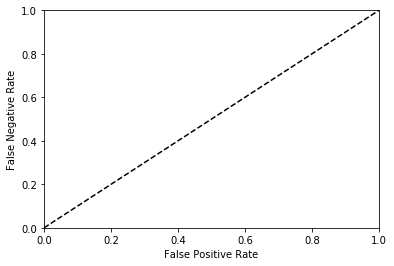

In [106]:
def plot_roc_curve( FPR_new,TPR_new):

    plt.clf()
    plt.plot(FPR_new, TPR_new, linewidth=2)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("False Negative Rate")

plot_roc_curve(fp_rate, TPR)
plt.show()

In [107]:
from sklearn.metrics import roc_curve

In [108]:
import sklearn.metrics as metrics

In [109]:
roc_auc = metrics.auc(FPR_new, TPR_new)

TypeError: Singleton array 0.49 cannot be considered a valid collection.

In [ ]:
roc_auc

In [ ]:
from sklearn.metrics import roc_curve, auc
# fpr, tpr, thresholds = roc_curve(actual, pred_list)
fpr = FPR_new
tpr = TPR_new
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % 50)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
FPR_new

In [ ]:
import matplotlib.pyplot as plt
plt.plot(FPR_new, TPR_new,'r-',label = 'Precision-Recall')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
# print (confusion_matrix)

In [ ]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("CM :",cm[0][1])
    FP = cm[0][0]
    TN = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    print('True positive = ', TP)
    print('False positive = ', FP)
    print('False negative = ', FN)
    print('True negative = ', TN)
    return TP,FP,FN,TN

In [ ]:
pred= [1,1,1,0,0]

In [ ]:
TP, FP, FN ,TN = print_confusion_matrix(actual, pred)

In [ ]:
a = confusion_matrix(actual,pred)

In [ ]:
a

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
# df_cm = pd.DataFrame(confusion_matrix, range(2),
#                   range(2))
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# plt.figure(figsize = (10,7))
# sn.set(font_scale=1.4)#for label size
# sn.heatmap(df_cm, annot=True,annot_kws={"size": 20})# font size

In [ ]:
print(TP)

In [ ]:
precision = TP / (TP + FP)
recall = TP / (TP+FN)
F_Score = (2*precision*recall)/(precision+recall)

In [ ]:
precision

In [ ]:
recall

In [ ]:
F_Score

In [ ]:
data = {'Precision':precision,'Recall':recall,'F-Score':F_Score}
pd.DataFrame.from_dict(data, orient='index',columns=[ 'Values'])

In [ ]:
inverse_precision = TN / (FN+TN)
inverse_recall = TN / (FP+TN)
markedness = precision + inverse_precision - 1
informedness = recall + inverse_recall - 1

In [ ]:
import math

In [ ]:
a = (TP+FN)

In [ ]:
b = math.sqrt((TP+FN)*(FP+TN)*(TP+FP)*(FN+TN))

In [ ]:
MCC = ((TP*TN) - (FN*FP))//b

In [ ]:
inverse_precision

In [ ]:
inverse_recall

In [ ]:
markedness

In [ ]:
informedness

In [ ]:
MCC

In [111]:
t_user_val

category_id,1,2,3,4,5,6,8,9,10,11,...,26,27,28,29,30,31,32,33,34,36
member_id,,,,,,,,,,,,,,,,,,,,,
159387072,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [121]:

lis_t = t_user_val.loc[159387072].to_list()

In [122]:
lis_t

[0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0]